In [4]:
import tensorflow as tf
layers = tf.keras.layers
import gym
import numpy as np

import argparse
import time

In [5]:
tf.enable_eager_execution()
tf.executing_eagerly()

True

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

# Imports specifically so we can render outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))



In [7]:
FLAGS = argparse.Namespace()

In [81]:
FLAGS.render = True
FLAGS.num_episodes = 200
FLAGS.agent_type = 'REINFORCE'

In [9]:
class RandomAgent(tf.keras.Model):
    def __init__(self, observation_space, action_space):
        super(RandomAgent, self).__init__()
        self.observation_space = observation_space
        self.action_space = action_space
        return
    def act(self, state):
        action = self.action_space.sample()
        return action

In [77]:
class REINFORCEAgent(tf.keras.Model):
    def __init__(self, observation_space, action_space):
        super(REINFORCEAgent, self).__init__()
        self.observation_space = observation_space
        self.action_space = action_space
        self.hidden_layer1 = layers.Dense(10,
                                          activation='relu',
                                          kernel_initializer=tf.contrib.layers.xavier_initializer())
        self.hidden_layer2 = layers.Dense(self.action_space.n, 
                                          activation='relu',
                                          kernel_initializer=tf.contrib.layers.xavier_initializer())
        self.logit_layer = layers.Dense(self.action_space.n, activation='linear',
                                          kernel_initializer=tf.contrib.layers.xavier_initializer())
        self.optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    def act(self, state):
        out = self.call(state)
        sample_action = tf.random.multinomial(out, 1)
        return sample_action[0, 0].numpy()
    def call(self, state):
        a = self.hidden_layer1(state)
        a = self.hidden_layer2(a)
        a = self.logit_layer(a)
        return a
        
    def train_one_episode(self, trajectory):
        episode_states  = [s for _, s, _, _, _ in trajectory]
        episode_action_indexes = [a for _, _, a, _ , _ in trajectory]
        episode_actions =[]
        for a in episode_action_indexes:
            one_hot = np.zeros(self.action_space.n)
            one_hot[a] = 1
            episode_actions.append(one_hot)
        episode_rewards = [r for _, _, _, _, r in trajectory]
        discounted_rewards = discount_and_normalize_rewards(episode_rewards)
        episode_states = np.vstack(episode_states)
        episode_actions = np.vstack(episode_actions)
        with tf.GradientTape() as tape:
            action_logits = self(episode_states)
            neg_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits=action_logits,labels=episode_actions)
            loss = tf.reduce_mean(neg_log_prob * discounted_rewards)
        grads = tape.gradient(loss, self.variables)
        self.optimizer.apply_gradients(zip(grads, self.variables))
            
            
    

In [ ]:
tf.GradientTape.gradient()

In [ ]:
v1 = tf.constant([1, 2])
v2 = tf.constant([3, 4])
tf.reduce_sum([v1, v2], axis= 0)

In [ ]:
tf.nn.softmax(tf.constant([0.3, 5]))

In [ ]:
tf.random.multinomial(tf.expand_dims(tf.log(probs), 0), 1)[0, 0].numpy()

In [11]:
def build_env():
    """Returns configured gym env"""
    env = gym.make('CartPole-v0')
    return env

In [12]:
def build_agent(observation_space, action_space, agent_type):
    """Returns initialized agent"""
    if agent_type == 'Random':
        agent = RandomAgent(observation_space, action_space)
    elif agent_type == 'REINFORCE':
        agent = REINFORCEAgent(observation_space, action_space)
    return agent

In [83]:
def main():
    envir = build_env()
    agent = build_agent(envir.observation_space, 
                        envir.action_space, FLAGS.agent_type)
    total_rewards = []
    running_avg_reward = 0.0
    for i in range(FLAGS.num_episodes):
        done = False
        obs = envir.reset()
        steps = 0
        total_reward = 0.0
        trajectory = []
        if FLAGS.render and i+1 == FLAGS.num_episodes:
            frames = []
        while not done:
            action = agent.act(tf.expand_dims(obs, 0))
            obs_prev = obs
            obs, reward, done, info = envir.step(action)
            traj_step = (steps, obs_prev, action, obs, reward)
            trajectory.append(traj_step)
            total_reward += reward
            steps += 1
            if FLAGS.render and i+1 == FLAGS.num_episodes:
                frames.append(envir.render(mode = 'rgb_array'))
        # Render to GIF
        if FLAGS.render and i+1 == FLAGS.num_episodes:
            envir.render()
            display_frames_as_gif(frames)
        #train
        running_avg_reward =  (total_reward + (i * running_avg_reward))/(i+1)
        if i % 10 == 0:
            print(running_avg_reward)
        agent.train_one_episode(trajectory)
        
        
    
        

In [49]:
env = build_env()
v = env.reset()

In [50]:
agent = REINFORCEAgent(env.observation_space, env.action_space)

/home/gray/.conda/envs/deep-learning/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


13.0
20.272727272727273
21.571428571428573
19.774193548387096
20.682926829268286
19.450980392156858
19.73770491803278
19.295774647887317
18.728395061728385
18.582417582417573
18.643564356435636
18.279279279279272
17.933884297520652
17.74045801526717
17.64539007092198
17.503311258278146
17.6024844720497
17.479532163742697
17.232044198895032
17.089005235602098



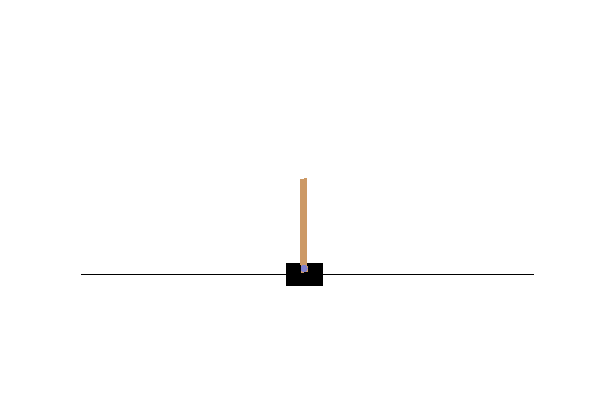
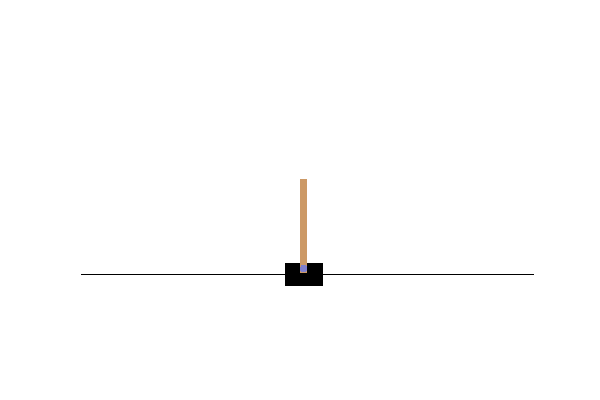
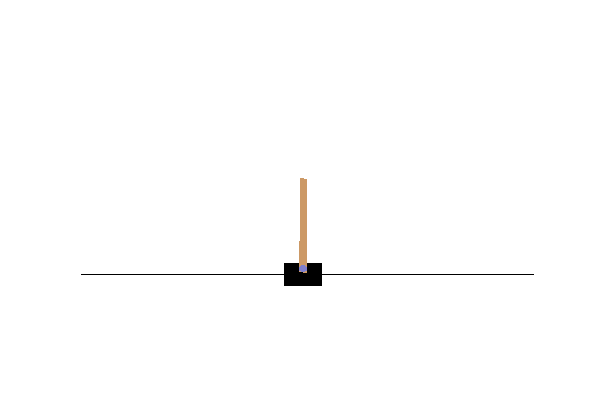
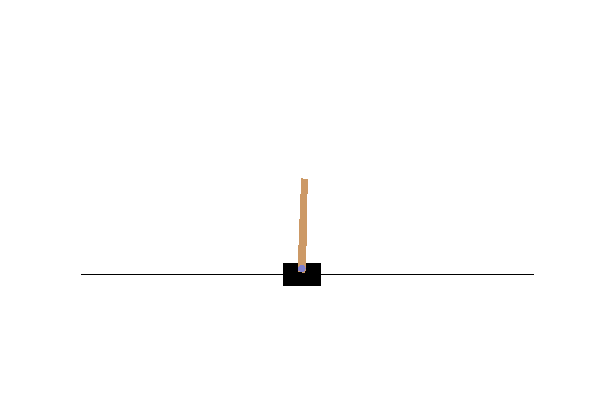
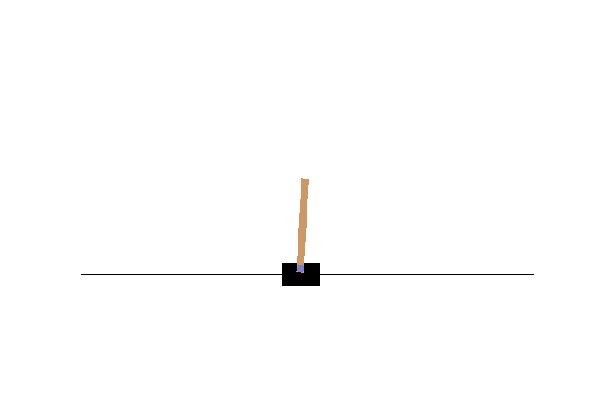
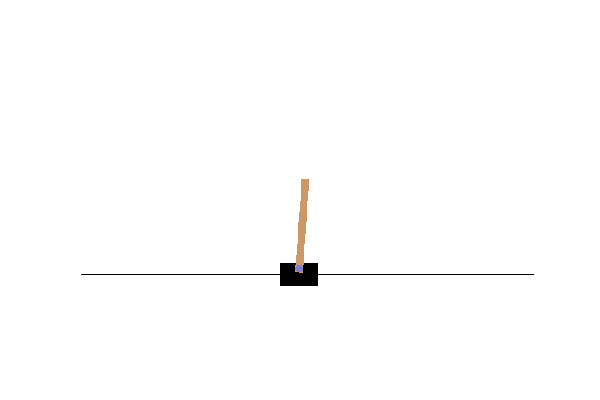
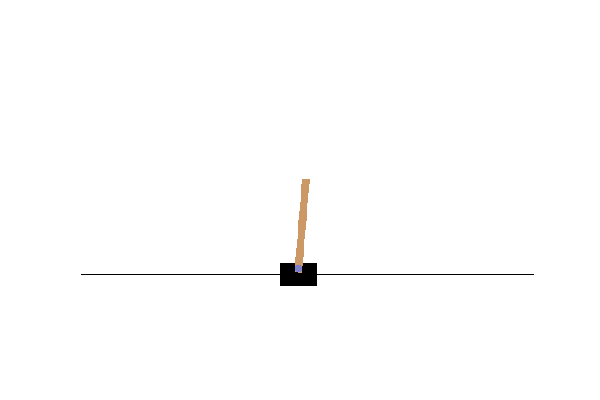
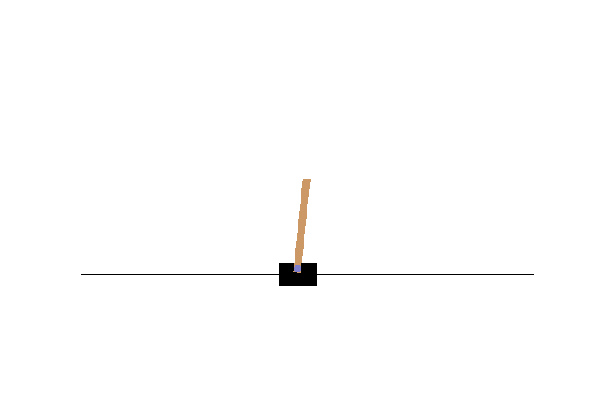
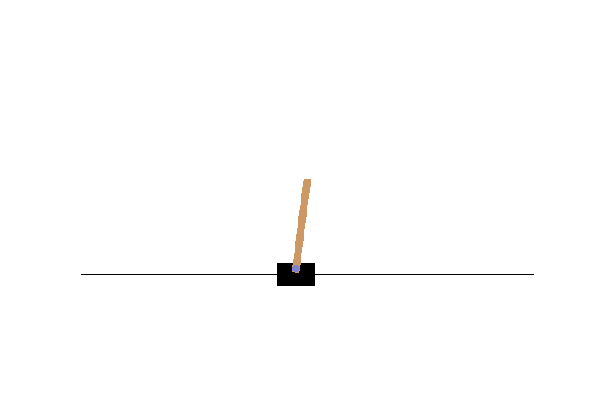
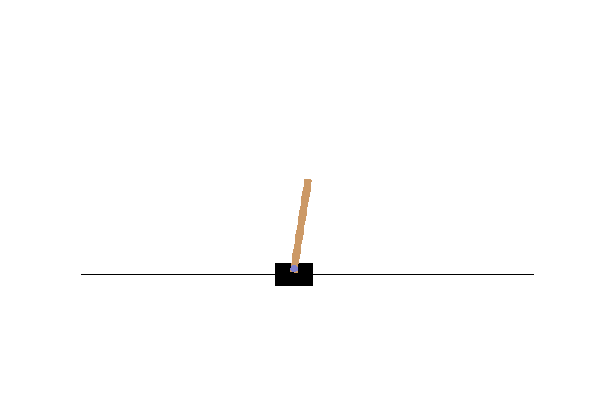
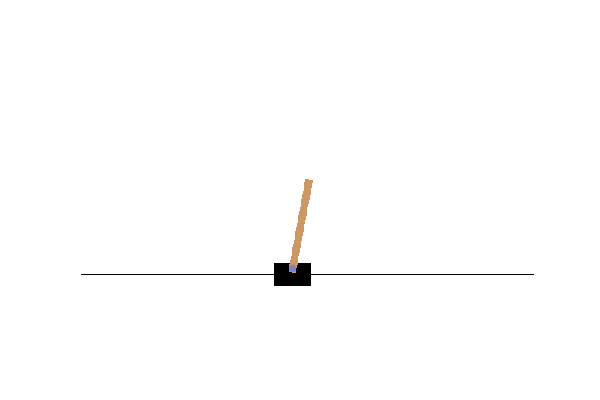
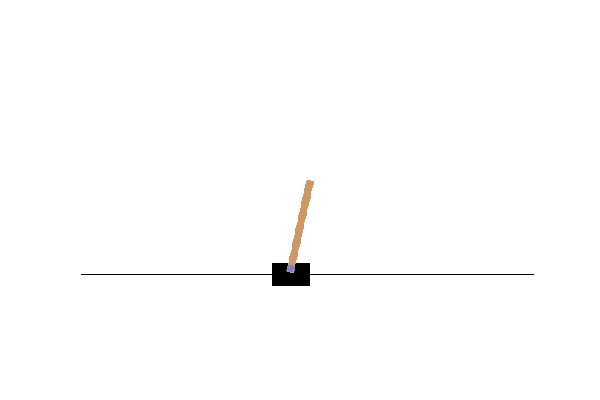

In [84]:
main()

In [14]:
def discounted_rewards(cur_step, trajectory, gamma):
    r = [(t, r) for t, _, _, _, r in trajectory]
    return [(t, r * gamma**(i-cur_step)) for i, (t, r) in enumerate(r) if i>=cur_step]

In [78]:
def discount_and_normalize_rewards(episode_rewards, gamma = 0.95):
    discounted_episode_rewards = np.zeros_like(episode_rewards)
    cumulative = 0.0
    for i in reversed(range(len(episode_rewards))):
        cumulative = cumulative * gamma + episode_rewards[i]
        discounted_episode_rewards[i] = cumulative
    
    #mean = np.mean(discounted_episode_rewards)
    mean = 0
    #std = np.std(discounted_episode_rewards)
    std = 1
    discounted_episode_rewards = (discounted_episode_rewards - mean) / (std)
    
    return discounted_episode_rewards



In [79]:
discount_and_normalize_rewards([1, 2, 2, 2, 4, 5])

array([13., 13., 11., 10.,  8.,  5.])